In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('../data/raw/train.csv')
df.columns = (
        df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w]", "", regex=True)
        .str.lower()
    )
df['date'] = pd.to_datetime(df['date']) # make sure date is valid
df = df.sort_values(['ticker', 'date']) # sort by date
grouped_by_ticker = df.groupby('ticker')

In [2]:
df_cleaned = pd.read_csv('../data/interim/train_clean.csv')
df_cleaned['date'] = pd.to_datetime(df_cleaned['date']) # make sure date is valid
df_cleaned = df_cleaned.sort_values(['ticker', 'date']) # sort by date
grouped_by_ticker_cleaned = df_cleaned.groupby('ticker')

# 1- What is the Distribution of days of each Ticker
# ما هو توزيع عدد أيام التداول لكل سهم؟

In [50]:
# grouped_by_ticker['date'].describe()
# grouped_by_ticker_cleaned['date'].describe()

from above table, we can see :

1- there is 5000 different tickers

2- start date differs(3060 start date), most of them end at same date except 10 records

3- records per ticker vary from 224 to 15789 records



In [51]:
grouped_by_ticker_size = grouped_by_ticker.size()

In [52]:
grouped_by_ticker_cleaned_size = grouped_by_ticker_cleaned.size()

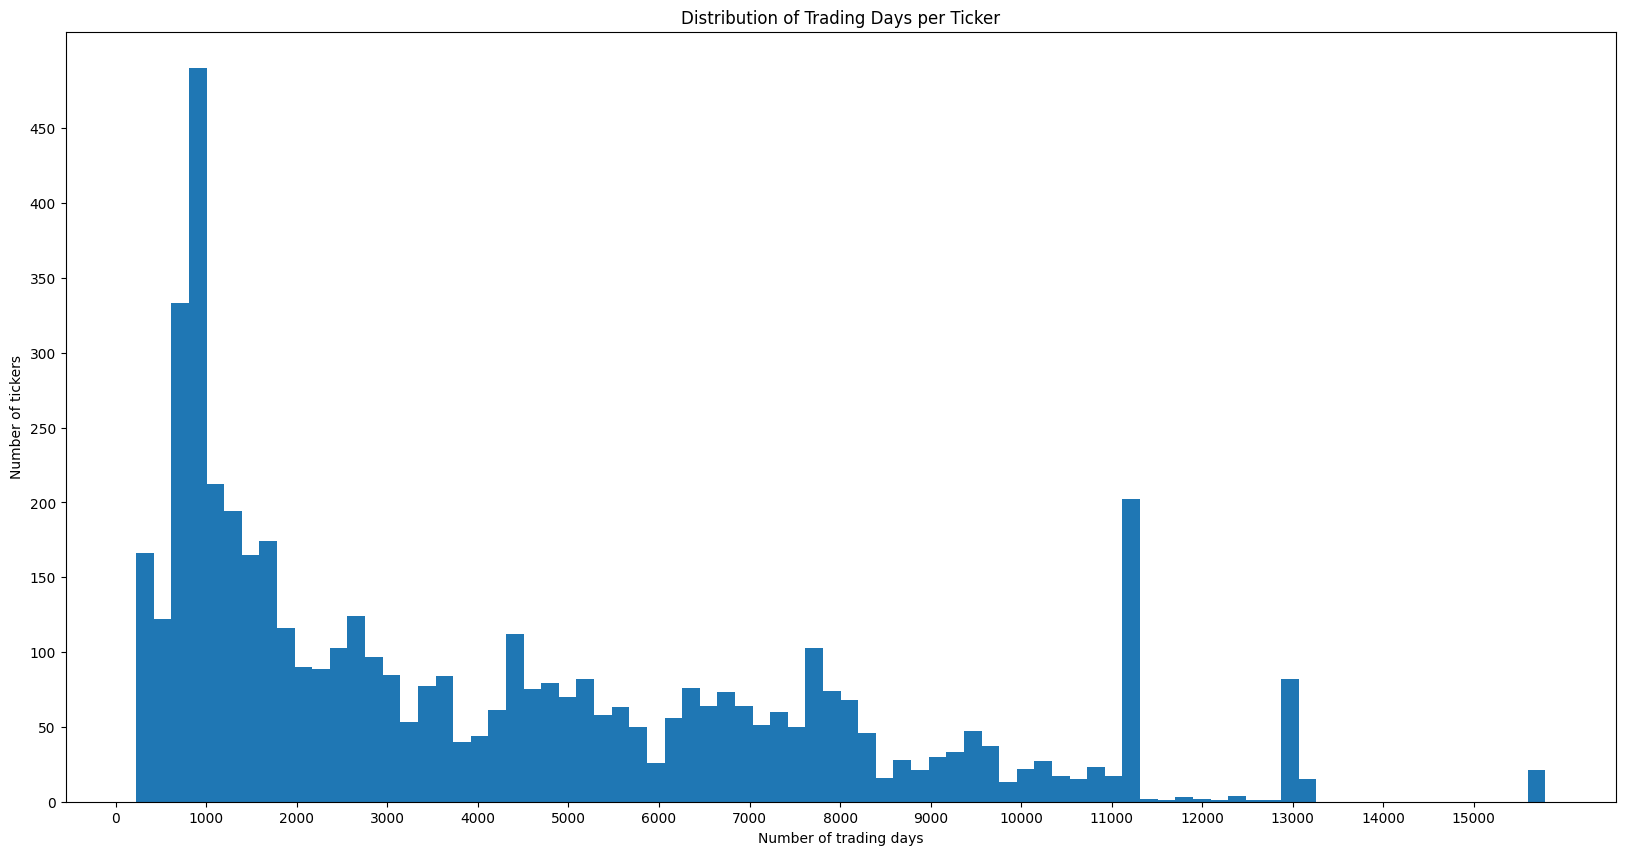

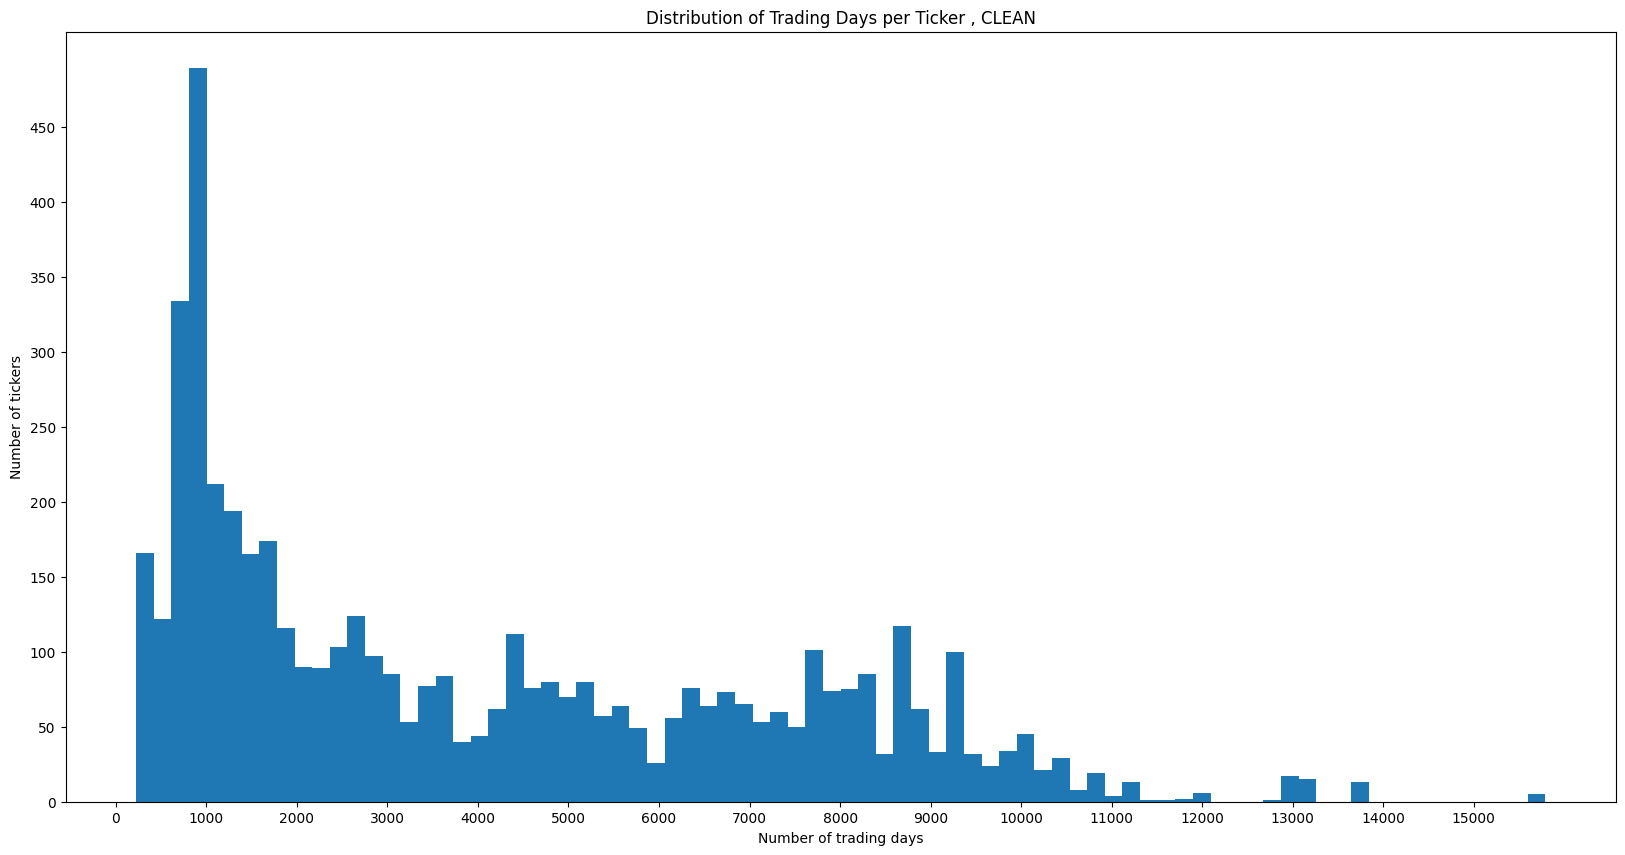

In [53]:
import numpy as np

plt.figure(figsize=(20, 10))
plt.hist(grouped_by_ticker_size, bins=80 )
plt.yticks(np.arange(0, 500, 50))
plt.xticks(np.arange(0, 16000, 1000))

# Add axis labels and a title
plt.xlabel("Number of trading days")
plt.ylabel("Number of tickers")
plt.title("Distribution of Trading Days per Ticker")

# Display the plot
plt.show()

plt.figure(figsize=(20, 10))
plt.hist(grouped_by_ticker_cleaned_size, bins=80 )
plt.yticks(np.arange(0, 500, 50))
plt.xticks(np.arange(0, 16000, 1000))

# Add axis labels and a title
plt.xlabel("Number of trading days")
plt.ylabel("Number of tickers")
plt.title("Distribution of Trading Days per Ticker , CLEAN")

# Display the plot
plt.show()


note: you can right click the plot then "show in plots" for more clear view
The distribution shows high variability in the number of trading days per ticker, with many stocks having relatively short histories and a small subset exhibiting very long trading records.

GPT comment:

التوزيع غير متوازن (long-tail)

تركّز كبير من الأسهم بين:
~500 إلى ~2000 يوم تداول

عدد أقل من الأسهم لديها تاريخ طويل جدًا
(10k–15k يوم ≈ شركات قديمة جدًا)

الاستنتاج الصحيح:

وجود تفاوت كبير في طول السلاسل الزمنية

كثير من الأسهم لا تملك تاريخًا كافيًا لبناء تسلسلات طويلة

هذا يفرض:

windowing ثابت (مثلاً 30 يوم)

padding أو masking لاحقًا



## Data Availability Range per Ticker
## هل جميع الأسهم تغطي نفس الفترة الزمنية؟


In [54]:
ticker_counts = grouped_by_ticker_size.sort_values(ascending=False)
ticker_counts_cleaned = grouped_by_ticker_cleaned_size.sort_values(ascending=False)


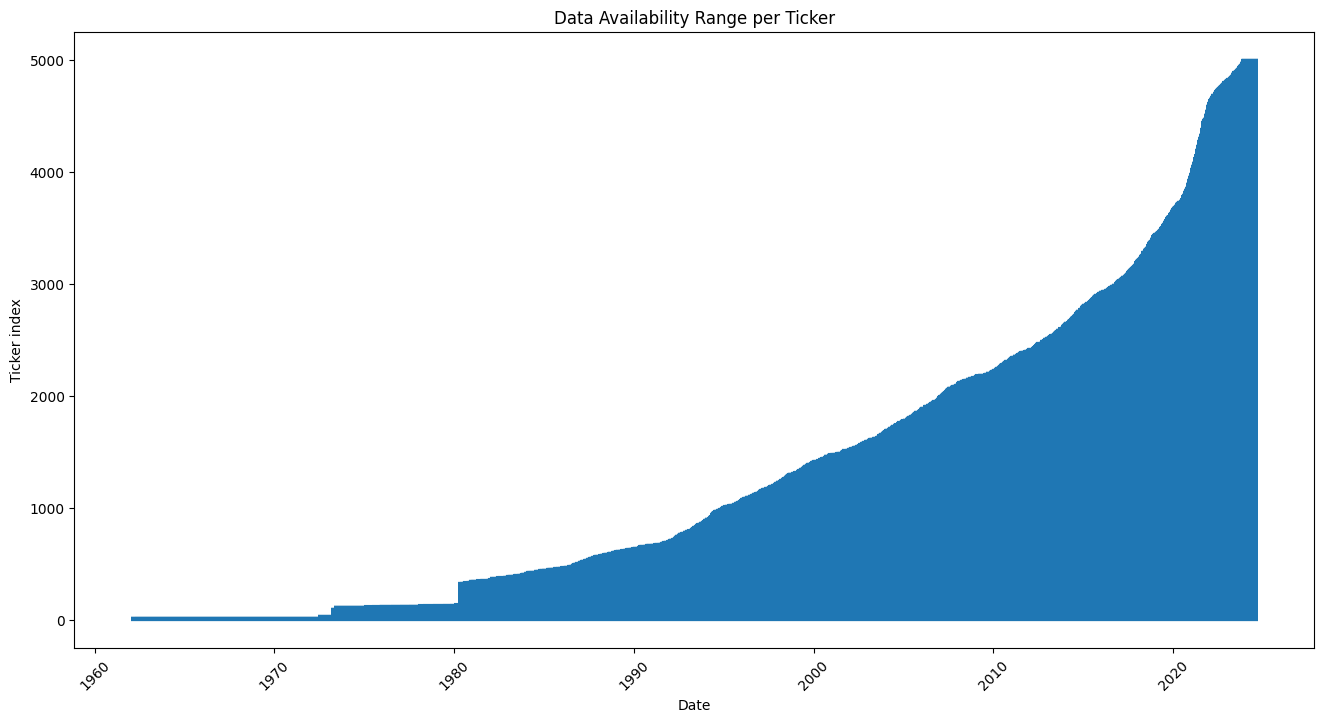

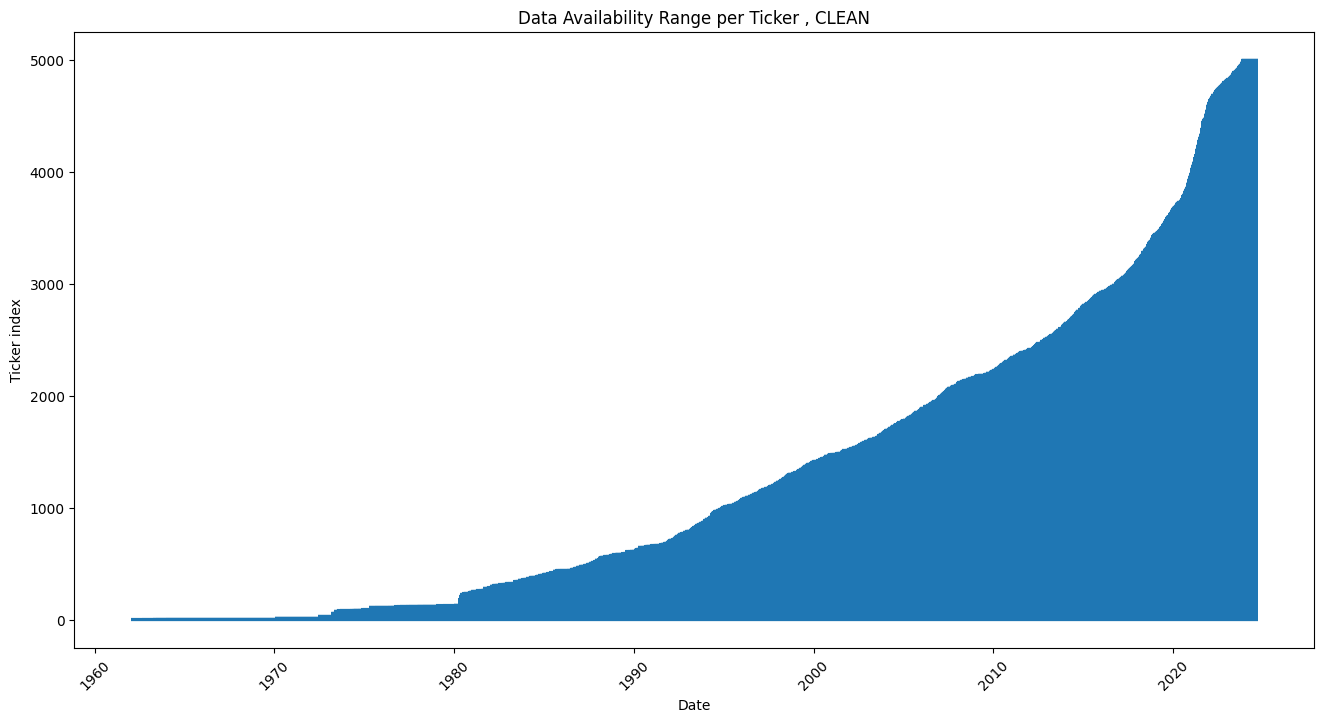

In [55]:
ranges = grouped_by_ticker['date'].agg(['min', 'max']).sort_values(['min'])
years = pd.date_range(start='1960-01-01', end='2025-01-01', freq='10YS')
plt.figure(figsize=(16, 8))
plt.hlines(
    y=range(len(ranges)),
    xmin=ranges['min'],
    xmax=ranges['max'],
    # linewidth=0.5
)

plt.xlabel("Date")
plt.ylabel("Ticker index")

plt.xticks(years, [d.year for d in years], rotation=45)

plt.title("Data Availability Range per Ticker")
plt.show()


ranges = grouped_by_ticker_cleaned['date'].agg(['min', 'max']).sort_values(['min'])
years = pd.date_range(start='1960-01-01', end='2025-01-01', freq='10YS')
plt.figure(figsize=(16, 8))
plt.hlines(
    y=range(len(ranges)),
    xmin=ranges['min'],
    xmax=ranges['max'],
    # linewidth=0.5
)

plt.xlabel("Date")
plt.ylabel("Ticker index")

plt.xticks(years, [d.year for d in years], rotation=45)

plt.title("Data Availability Range per Ticker , CLEAN")
plt.show()

The temporal coverage varies significantly across tickers.

Many stocks enter the dataset decades after others, indicating that a global aligned timeline is not feasible.


GPT Comment:

الأسهم لا تبدأ في نفس الزمن

عدد كبير يبدأ بعد:

1980

1990

حتى بعد 2000

قلة فقط تغطي 1960–2024

الاستنتاج الصحيح:

لا يوجد تزامن زمني موحّد بين الأسهم

لا يمكن بناء نموذج يعتمد على:

نفس التاريخ لكل الأسهم

يجب التعامل مع كل سهم كسلسلة مستقلة

## Distribution of Longest Continuous Trading Sequences
 ## توزيع أطول سلسلة تداول متصلة لكل سهم

In [56]:
MAX_NORMAL_GAP = 3 #  2 days are fine
# , e.g: 1 , 2, 3 ,4 ,
#  2 and 3 are missing , 4-1 = 3.

def max_continuous_length(group):
    dates = group['date'].sort_values()

    # difference in days
    gaps = dates.diff().dt.days

    # new segment whenever gap > MAX_NORMAL_GAP
    segment_id = (gaps > MAX_NORMAL_GAP).cumsum()

    # count length of each segment
    segment_lengths = segment_id.value_counts()

    return segment_lengths.max()


max_continuous_lengths = (
    grouped_by_ticker
    .apply(max_continuous_length, include_groups = False )
)

max_continuous_lengths_cleaned = (
    grouped_by_ticker_cleaned
    .apply(max_continuous_length, include_groups = False )
)



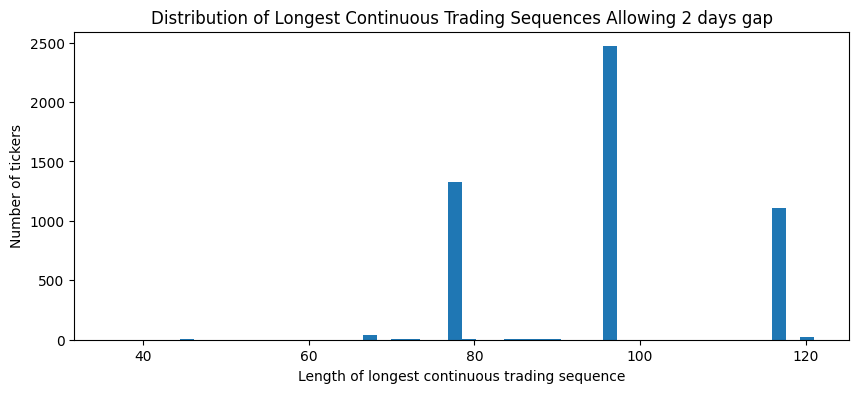

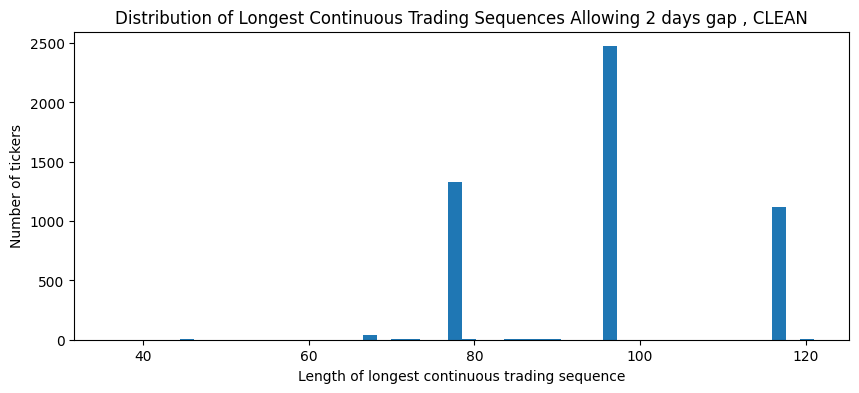

In [57]:
plt.figure(figsize=(10, 4))
plt.hist(max_continuous_lengths, bins=50)
plt.xlabel("Length of longest continuous trading sequence")
# plt.xticks(np.arange(0,120 , 1))
plt.ylabel("Number of tickers")
# plt.yticks(np.arange(0,2400 , 100))
plt.title("Distribution of Longest Continuous Trading Sequences Allowing 2 days gap")
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(max_continuous_lengths_cleaned, bins=50)
plt.xlabel("Length of longest continuous trading sequence")
# plt.xticks(np.arange(0,120 , 1))
plt.ylabel("Number of tickers")
# plt.yticks(np.arange(0,2400 , 100))
plt.title("Distribution of Longest Continuous Trading Sequences Allowing 2 days gap , CLEAN")
plt.show()


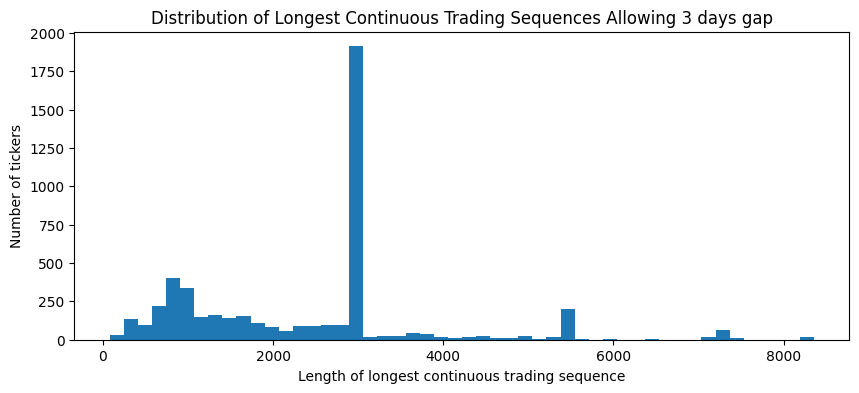

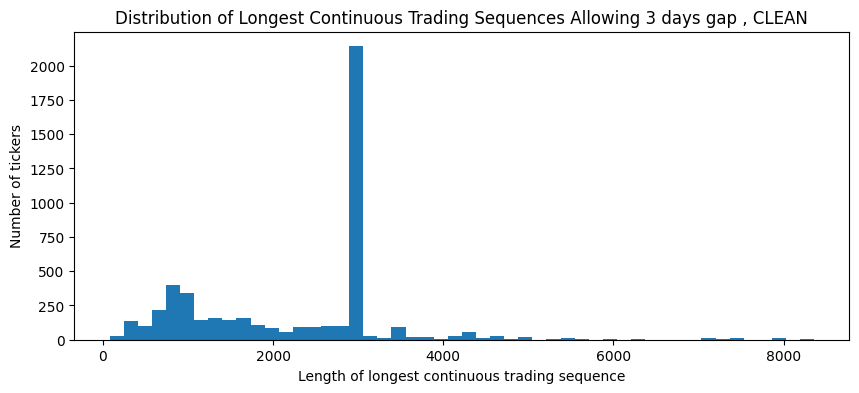

In [58]:
MAX_NORMAL_GAP = 4 #  3 days are fine
max_continuous_lengths = (
    grouped_by_ticker
    .apply(max_continuous_length, include_groups = False )
)
max_continuous_lengths_cleaned = (
    grouped_by_ticker_cleaned
    .apply(max_continuous_length, include_groups = False )
)
plt.figure(figsize=(10, 4))
plt.hist(max_continuous_lengths, bins=50)
plt.xlabel("Length of longest continuous trading sequence")
# plt.xticks(np.arange(0,120 , 1))
plt.ylabel("Number of tickers")
# plt.yticks(np.arange(0,2400 , 100))
plt.title("Distribution of Longest Continuous Trading Sequences Allowing 3 days gap")
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(max_continuous_lengths_cleaned, bins=50)
plt.xlabel("Length of longest continuous trading sequence")
# plt.xticks(np.arange(0,120 , 1))
plt.ylabel("Number of tickers")
# plt.yticks(np.arange(0,2400 , 100))
plt.title("Distribution of Longest Continuous Trading Sequences Allowing 3 days gap , CLEAN")
plt.show()


Allowing 2 days of absence:
The longest continuous trading sequences are relatively short for most tickers, with the majority not exceeding 100 trading days.
This supports the use of short fixed-length windows for RNN-based modeling.

allowing 3 days of absence:
The longest continuous trading sequences increased to reach more than 8000 for some tickers , top value is around 3000 continuous days for more than 1800 tickers.
GPT Comment:

قمم واضحة حول:

~75

~95

~120 يوم تداول

عدد كبير من الأسهم أطول سلسلة متصلة عندها أقل من 100 يوم

ماذا يعني هذا؟

أغلب الأسهم لا تملك سلاسل طويلة متصلة

لكن:

30 يوم window ✔️

60 يوم ممكن لبعض الأسهم

100 يوم ❌ لمعظم الأسهم

استنتاج حاسم:

اختيار window = 30 يوم منطقي جدًا

RNN بطول طويل سيكون:

غير مستقر

أو سيضطر للتقطيع



## Gaps


In [59]:
MAX_NORMAL_GAP = 3 #  2 days are fine
df["prev_date"] = grouped_by_ticker["date"].shift(1)
df["gap_days"] = (df["date"] - df["prev_date"]).dt.days
gaps = df[df["gap_days"] > MAX_NORMAL_GAP].copy()
gaps["missing_days"] = gaps["gap_days"] - 1

df_cleaned["prev_date"] = grouped_by_ticker_cleaned["date"].shift(1)
df_cleaned["gap_days"] = (df_cleaned["date"] - df_cleaned["prev_date"]).dt.days
gaps_cleaned = df_cleaned[df_cleaned["gap_days"] > MAX_NORMAL_GAP].copy()
gaps_cleaned["missing_days"] = gaps_cleaned["gap_days"] - 1


In [60]:
gaps[["ticker", "prev_date", "date", "missing_days"]]


,ticker,prev_date,date,missing_days
1572,ticker_1,1962-04-19,1962-04-23,3.0
3514,ticker_1,1962-08-31,1962-09-04,3.0
6025,ticker_1,1963-02-21,1963-02-25,3.0
6720,ticker_1,1963-04-11,1963-04-15,3.0
8798,ticker_1,1963-08-30,1963-09-03,3.0
...,...,...,...,...
20165666,ticker_999,2024-01-12,2024-01-16,3.0
20287678,ticker_999,2024-02-16,2024-02-20,3.0
20424402,ticker_999,2024-03-28,2024-04-01,3.0
20626335,ticker_999,2024-05-24,2024-05-28,3.0


In [61]:
gaps_cleaned[["ticker", "prev_date", "date", "missing_days"]]

,ticker,prev_date,date,missing_days
10601,ticker_1,1970-02-20,1970-02-24,3.0
11015,ticker_1,1970-03-26,1970-03-30,3.0
12251,ticker_1,1970-07-02,1970-07-06,3.0
13067,ticker_1,1970-09-04,1970-09-08,3.0
14442,ticker_1,1970-12-24,1970-12-28,3.0
...,...,...,...,...
19357731,ticker_999,2024-01-12,2024-01-16,3.0
19479743,ticker_999,2024-02-16,2024-02-20,3.0
19616467,ticker_999,2024-03-28,2024-04-01,3.0
19818400,ticker_999,2024-05-24,2024-05-28,3.0


In [62]:
gaps["missing_days"].value_counts().sort_index()


missing_days
3.0     555192
4.0       4663
5.0         57
6.0       1546
7.0         10
8.0          3
9.0          2
10.0         1
11.0         3
12.0         4
13.0         5
14.0         1
29.0         1
Name: count, dtype: int64

In [63]:
gaps_cleaned["missing_days"].value_counts().sort_index()


missing_days
3.0       541281
4.0         8818
5.0         3403
6.0         4380
7.0         1630
           ...  
4206.0         1
4536.0         1
4590.0         1
4645.0         3
5249.0         1
Name: count, Length: 604, dtype: int64

In [64]:
gaps[gaps["missing_days"] == 6][
    ["ticker", "prev_date", "date", "missing_days"]
].sort_values("missing_days", ascending=False)


,ticker,prev_date,date,missing_days
4574857,ticker_1,2001-09-10,2001-09-17,6.0
4574170,ticker_10,2001-09-10,2001-09-17,6.0
4574485,ticker_100,2001-09-10,2001-09-17,6.0
4574991,ticker_1000,2001-09-10,2001-09-17,6.0
4574912,ticker_1001,2001-09-10,2001-09-17,6.0
...,...,...,...,...
4574980,ticker_995,2001-09-10,2001-09-17,6.0
4574494,ticker_996,2001-09-10,2001-09-17,6.0
4573793,ticker_997,2001-09-10,2001-09-17,6.0
4573720,ticker_998,2001-09-10,2001-09-17,6.0


In [65]:
plot_data = gaps[gaps["missing_days"] == 4] \
    .groupby("prev_date")["Ticker"] \
    .nunique() \
    .sort_values(ascending=False)


KeyError: 'Column not found: Ticker'

In [ ]:
import matplotlib.pyplot as plt
gap_size = 3
# Assign your result to a variable
gap_counts = gaps[gaps["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

gap_counts = gaps_cleaned[gaps_cleaned["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps - CLEAN")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
gap_size = 4
# Assign your result to a variable
gap_counts = gaps[gaps["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

gap_counts = gaps_cleaned[gaps_cleaned["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps - CLEAN")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
gap_size = 5
# Assign your result to a variable
gap_counts = gaps[gaps["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

gap_counts = gaps_cleaned[gaps_cleaned["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps - CLEAN")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
gap_size = 6
# Assign your result to a variable
gap_counts = gaps[gaps["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

gap_counts = gaps_cleaned[gaps_cleaned["missing_days"] ==gap_size ] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_values(ascending=True)

# Plot the top 20 dates
# kind='bar' creates a bar chart
# figsize=(10, 6) makes it large enough to read
gap_counts.plot(kind='bar', figsize=(10, 6), title="Dates with the 3-Day Gaps - CLEAN")
plt.xticks([])
plt.ylabel("Count of Tickers")
plt.xlabel("Date")
plt.show()

In [ ]:
# Group, Count, and then Sort by DATE (Index), not by count
time_series_data = gaps[gaps["missing_days"] == 3] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_index() # Sort chronologically

# Plot as a line chart to show spikes over time
time_series_data.plot(kind='line', figsize=(12, 6), title="Frequency of 3-Day Gaps Over Time")
plt.ylabel("Count of Tickers")
plt.show()

In [ ]:
# Group, Count, and then Sort by DATE (Index), not by count
time_series_data = gaps_cleaned[gaps_cleaned["missing_days"] == 3] \
    .groupby("prev_date")["ticker"] \
    .nunique() \
    .sort_index() # Sort chronologically

# Plot as a line chart to show spikes over time
time_series_data.plot(kind='line', figsize=(12, 6), title="Frequency of 3-Day Gaps Over Time - CLEAN")
plt.ylabel("Count of Tickers")
plt.show()

In [ ]:
import pandas as pd

df_invlaid = pd.read_csv('../data/raw/invalid_rows.csv')
df_invlaid['date'] = pd.to_datetime(df_invlaid['date'])  # make sure date is valid
df_invlaid = df_invlaid.sort_values(['ticker', 'date'])  # sort by date
grouped_by_ticker_invalid = df_invlaid.groupby('ticker')
grouped_by_ticker_invalid.describe()
ranges_clean = (
    grouped_by_ticker_cleaned['date']
    .agg(['min', 'max'])
)

ranges_invalid = (
    grouped_by_ticker_invalid['date']
    .agg(['min', 'max'])
)


def coverage_by_year(ranges, years):
    return [
        ((ranges['min'] <= y) & (ranges['max'] >= y)).sum()
        for y in years
    ]


years = pd.date_range('1960-01-01', '2025-01-01', freq='YS')

clean_counts = coverage_by_year(ranges_clean, years)
invalid_counts = coverage_by_year(ranges_invalid, years)
clean_counts = (
    grouped_by_ticker_cleaned
    .size()
    .rename('clean_rows')
)

invalid_counts = (
    grouped_by_ticker_invalid
    .size()
    .rename('invalid_rows')
)
table = (
    pd.concat([clean_counts, invalid_counts], axis=1)
    .fillna(0)
)

# keep only tickers with invalid data
table = table[table['invalid_rows'] > 0]
table['total_rows'] = table['clean_rows'] + table['invalid_rows']

table['percent_invalid'] = (
        100 * table['invalid_rows'] / table['total_rows']
)
table = table.sort_values(
    by='percent_invalid',
    ascending=False
)
table

####
import matplotlib.pyplot as plt

ranges = grouped_by_ticker_invalid['date'].agg(['min', 'max']).sort_values(['min'])
years = pd.date_range(start='1960-01-01', end='2025-01-01', freq='10YS')
plt.figure(figsize=(16, 8))
plt.hlines(
    y=range(len(ranges)),
    xmin=ranges['min'],
    xmax=ranges['max'],
    # linewidth=0.5
)
import numpy as np

plt.xlabel("date")
plt.ylabel("ticker index")
plt.yticks(np.arange(0, 5000, 1000))
plt.xticks(years, [d.year for d in years], rotation=45)

plt.title("Data Availability Range per ticker")
plt.show()

years = pd.date_range('1960-01-01', '2025-01-01', freq='YS')

clean_counts = coverage_by_year(ranges_clean, years)
invalid_counts = coverage_by_year(ranges_invalid, years)
clean_counts = (
    grouped_by_ticker_cleaned

    .size()
    .rename('clean_rows')
)

invalid_counts = (
    grouped_by_ticker_invalid
    .size()
    .rename('invalid_rows')
)
table = (
    pd.concat([clean_counts, invalid_counts], axis=1)
    .fillna(0)
)

# keep only tickers with invalid data
table = table[table['invalid_rows'] > 0]
table['total_rows'] = table['clean_rows'] + table['invalid_rows']

table['percent_invalid'] = (
        100 * table['invalid_rows'] / table['total_rows']
)
table = table.sort_values(
    by='percent_invalid',
    ascending=False
)
clean_dates = (
    df_cleaned
    .groupby('ticker')['date']
    .agg(clean_start='min', clean_end='max')
)

invalid_dates = (
    df_invlaid
    .groupby('ticker')['date']
    .agg(invalid_start='min', invalid_end='max')
)

table = (
    table
    .join(clean_dates, how='left')
    .join(invalid_dates, how='left')
)
table


In [ ]:

table['overall_start'] = table[['clean_start', 'invalid_start']].min(axis=1)
table['overall_end']   = table[['clean_end', 'invalid_end']].max(axis=1)
table = table[[
    'total_rows',
    'invalid_rows',
    'clean_rows',
    'percent_invalid',
    'overall_start',
    'overall_end',
    'invalid_start',
    'invalid_end'
]]
assert table['overall_start'].notna().all()
assert table['overall_end'].notna().all()
